
# Projet sous Spark : accidents de la circulation en France entre 2012 et 2019


Auteur : Ivanhoé Botcazou


Date : 26 octobre 2023


## Analyse des données avec les outils de Spark


Les données misent à notre disposition sont des tableaux au format 'csv'. Nous retrouvons par année différentes modalités sur les accidents de la circulation routière : caractéristiques, usagers, lieux et véhicules. Dans une première phase d'exploration des données, nous chercherons à répondre aux questions suivantes :


* Quelle est l'évolution du nombre d'accidents de la circulation en France par année ?
* Y a-t-il une région française plus touchée par les accidents de la circulation ?
* Quelles sont les 30 communes ou il y a le plus d'accidents de la route sur les années 2012 et 2018 ?
* Quelle période de l'année recense le plus d'accidents ?
* Le niveau d'éclairage au moment de l'accident est-il un facteur aggravant ?
* Quelle est l'évolution du nombre de morts et de blessés sur la route en France par année ?
* Quelles sont les 10 catégories de véhicules les plus meurtrières sur ces années pour les conducteurs ?
* Quelle classe d'âge est la plus touchée dans des accidents meurtriers sur la route ?
* Quelles sont les 100 personnes les plus impliquées dans des accidents de la route sur ces années d'études ?



In [2]:
#Modules

import os 
from pyspark.sql import SparkSession
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sn 

from pyspark.sql.types import StringType #Type pour une colonne 

from functools import reduce #empiler tous les DataFrames
from pyspark.sql import DataFrame


from pyspark.sql.functions import * 


### Chargement des données et exploration

In [3]:
#Chargement des données

spark = SparkSession.builder.master("local").appName('Botcazou').getOrCreate() #initialiser l'environement Spark


path = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Informatique_charbonel_Marie/DATA_Marie/projet_spark'

Annees = range(2012,2019)

car,usa,lieux,vehi = {},{},{},{} #Dico qui vont contenir les DataFrames Spark

for a in Annees:
    car[f'car_{a}'] = spark.read.load(path + f"/caracteristiques_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")
    usa[f'usa_{a}'] = spark.read.load(path + f"/usagers_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")
    lieux[f'lieux_{a}'] = spark.read.load(path + f"/lieux_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")
    vehi[f'vehi_{a}'] = spark.read.load(path + f"/vehicules_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")

23/11/07 08:10:02 WARN Utils: Your hostname, ibotcazou-Latitude-7480 resolves to a loopback address: 127.0.1.1, but we couldn't find any external IP address!
23/11/07 08:10:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/07 08:10:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/07 08:10:03 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: 4e:37:0e:11:97:75:f5:2d
23/11/07 08:10:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
#Visualisation du dataset Caractéristiques année 2012
car['car_2012'].show(14)

print(type(car['car_2012'])) # <class 'pyspark.sql.dataframe.DataFrame'>

+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
|     Num_Acc| an|mois|jour|hrmn|lum|agg|int|atm|col|com|                 adr|gps|    lat|  long|dep|
+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
|201200000001| 12|   3|  16|1930|  5|  2|  1|  1|  6| 11|33 Rue Roger Sale...|  M|5052928|293643|590|
|201200000002| 12|   9|   1|2145|  5|  2|  1|  1|  3| 11|        route de DON|  M|5053380|292738|590|
|201200000003| 12|  11|  20|1815|  5|  2|  1|  1|  5|670|  rue Anatole France|  M|5054757|292033|590|
|201200000004| 12|   1|   7|1915|  5|  2|  1|  1|  3| 51|      Rue d'ESTAIRES|  M|5053315|280229|590|
|201200000005| 12|   1|  17|2000|  5|  2|  1|  1|  1|524|Rue du G�n�ral Le...|  M|5055855|290642|590|
|201200000006| 12|   1|  22|1800|  5|  2|  1|  1|  6| 51|  34 rue de la Marne|  M|5053665|280409|590|
|201200000007| 12|   4|  14|1645|  1|  2|  1|  1|  6| 51|      13 RUE DE LENS|  M|

In [4]:
# Connaître la nature des colonnes

car['car_2012'].printSchema()


root
 |-- Num_Acc: long (nullable = true)
 |-- an: integer (nullable = true)
 |-- mois: integer (nullable = true)
 |-- jour: integer (nullable = true)
 |-- hrmn: integer (nullable = true)
 |-- lum: integer (nullable = true)
 |-- agg: integer (nullable = true)
 |-- int: integer (nullable = true)
 |-- atm: integer (nullable = true)
 |-- col: integer (nullable = true)
 |-- com: integer (nullable = true)
 |-- adr: string (nullable = true)
 |-- gps: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: integer (nullable = true)
 |-- dep: integer (nullable = true)



### Évolution du nombre d'accidents de la circulation en France par année.

Pour cette question nous allons utiliser le nombre de lignes des tableaux 'Caractéristiques' par années. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


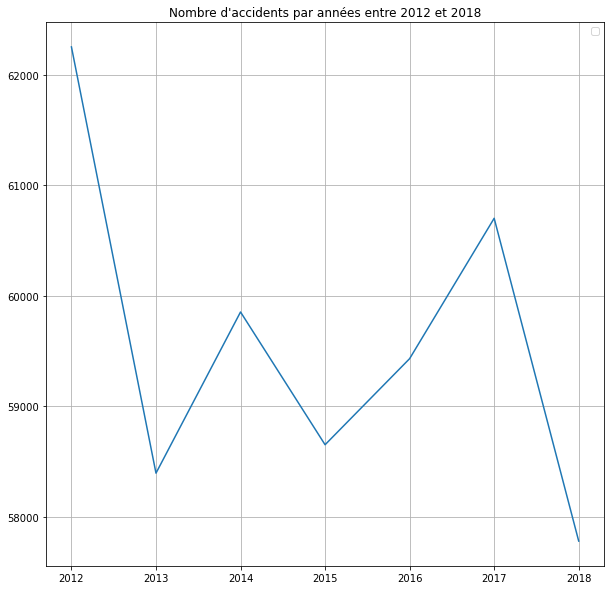

In [4]:
# Nombre d'accidents par ans

nb_acc = []
for i in Annees:
    nb_acc.append(car[f'car_{i}'].count()) # Compte le d'accident par année et les stock

plt.figure(figsize=(10,10))
plt.plot(Annees,nb_acc)
plt.grid()
plt.title("Nombre d'accidents par années entre 2012 et 2018" )
plt.legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

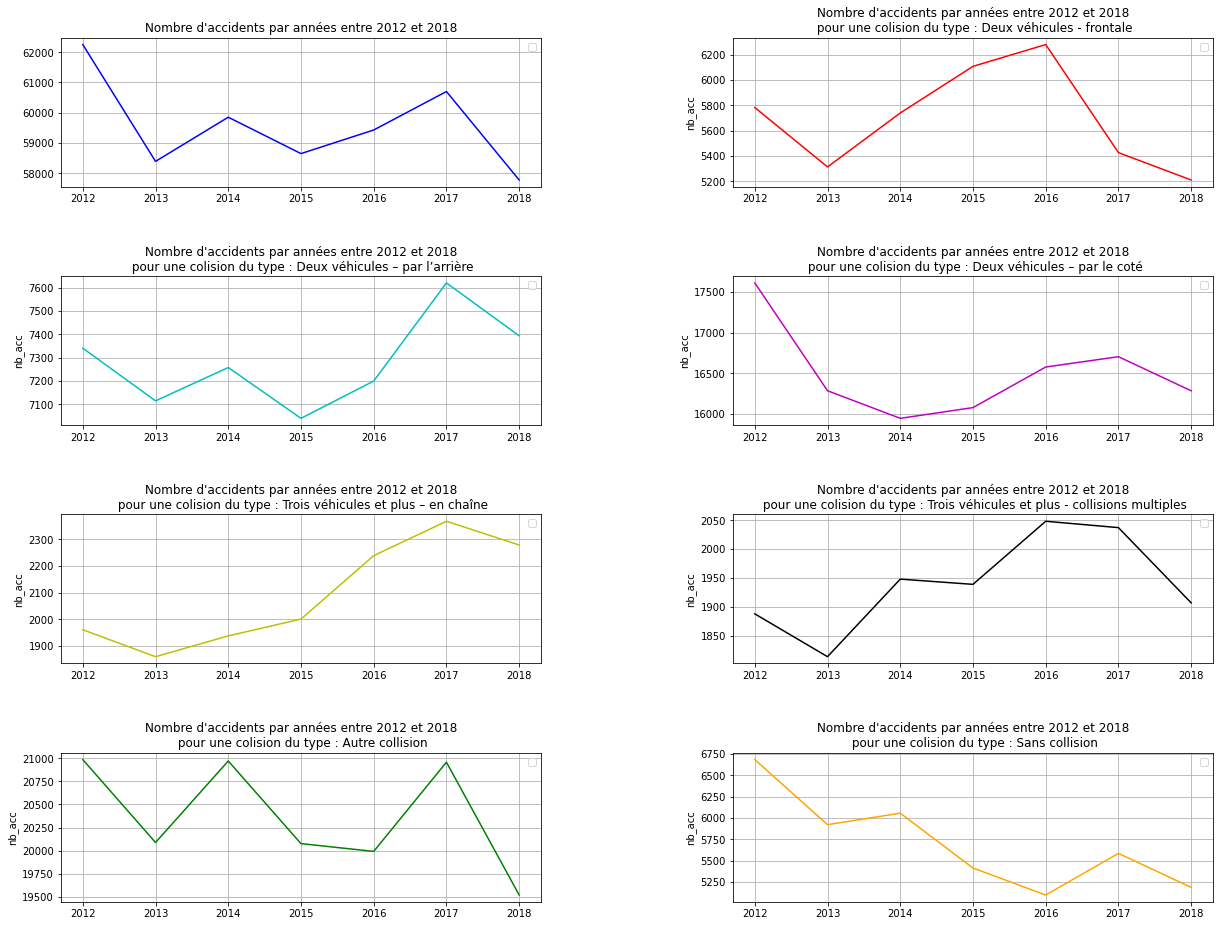

In [5]:
#Nombre d'accidents par type de colision 

type_col = range(1,8)
nb_ac_col = {f'col_{i}':[] for i in type_col} # Dico avec une liste par type de colisions

for a in Annees:
    for col in type_col:
        nb_ac_col[f'col_{col}'].append(car[f'car_{a}'].filter(car[f'car_{a}']['col']==col).count()) # fait un filtre et compte pour l'année voulue


#Partie plot 

plt.figure(figsize=(20,15))
# Définir une palette de couleurs
colors = ['g', 'r', 'c', 'm', 'y', 'k','g','orange']
coli = {1 : 'Deux véhicules - frontale',
2 : 'Deux véhicules – par l’arrière',
3 : 'Deux véhicules – par le coté',
4 : 'Trois véhicules et plus – en chaîne',
5 : 'Trois véhicules et plus - collisions multiples',
6 : 'Autre collision',
7 :'Sans collision'}


plt.subplot(4,2,1)
plt.plot(Annees,nb_acc,c='b')
plt.grid()
plt.title("Nombre d'accidents par années entre 2012 et 2018" )
plt.legend()
for j in range(1,8):
    plt.subplot(4,2,j+1)
    plt.plot(Annees,nb_ac_col[f'col_{j}'],c=colors[j])
    plt.ylabel("nb_acc")
    plt.grid()
    plt.title(f"Nombre d'accidents par années entre 2012 et 2018\n pour une colision du type : {coli[j]}" )
    plt.legend()

# Ajustement de l'espacement
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

plt.show()




## Zone géographique française avec le plus de recensement d'accidents de la circulation en fonction des années

Nous allons partager la France en 6 parties distinctes entre le nord, le sud, l'ouest, l'est et le centre (NO,NC,NE,SO,SC,SE). Approximativement, les villes repères pour la longitude sont Le Mans et Reims, pour la latitude nous avons choisi Bourge. 

D'après le tableau caractéristique, les colonnes lat et long contiennent des coordonnées GPS, mais dans un format non standard. Il est possible que ces valeurs représentent des coordonnées en degrés décimaux, mais avec un format différent. Une méthode pour convertir ces valeurs en format de longitude et latitude en degrés décimaux standard (DD) serait de divisez-les par 100 000 pour obtenir des degrés décimaux (puisque 1 degré = 100 kilomètres environ à la surface de la terre), ceci en supposant que les valeurs sont en centimètres. Cette estimation est basique et fonctionne mieux pour des emplacements qui ne sont pas proches des pôles. La France n'étant pas proche des pôles, nous accepterons cette approximation dans ce projet. 

In [7]:
CAT_GPS = ["NO","NC","NE","SO","SC","SE"] #Région géographique

def Find_CAT(gps):
    CAT = ""
    if gps[0]<=47: #critère de latitude
        CAT = "S"
    else:
        CAT = "N"
    if gps[1]<= 0: #critère de longitude
        CAT += "O"
    elif gps[1]>= 4:
        CAT += "E"
    else:
        CAT += "C"
    return CAT 

# Fonction pour convertir les coordonnées UTM en Lat/Long
def convert(lat, lon):
    try:
        return Find_CAT([float(lat)/ 100000, float(lon)/ 100000])
         # /!\ le format GPS n'est pas conventionnel 
         #Diviser par 100000 
    except (TypeError, ValueError):
        return None 



In [8]:
df = {}

# Créer UDF pour Spark, une méthode pour créer une nouvelle colonne en lien avec d'autres colonne et une fonction
convert_udf = udf(convert, StringType())

for a in Annees:
    df[f"{a}"] = car[f'car_{a}'].filter(car[f'car_{a}']['gps']=='M') # filtre pour n'avoir que les ligne avec données gps
    
    # Appliquer l'UDF pour créer une nouvelle colonne 'CAT' 
    df[f"{a}"] = df[f"{a}"].withColumn("CAT", convert_udf(df[f"{a}"]["lat"], df[f"{a}"]["long"]))
    df[f"{a}"] = df[f"{a}"].filter(df[f"{a}"]['CAT']!= "NULL")



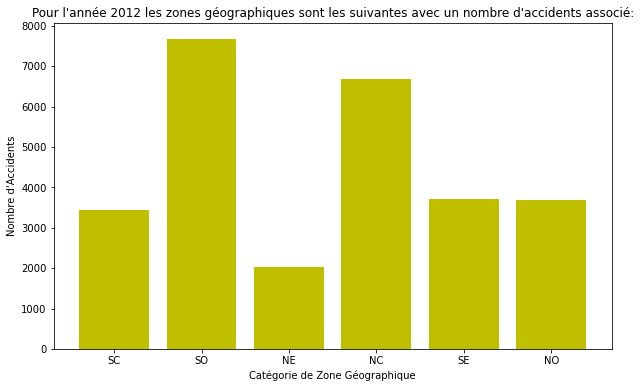

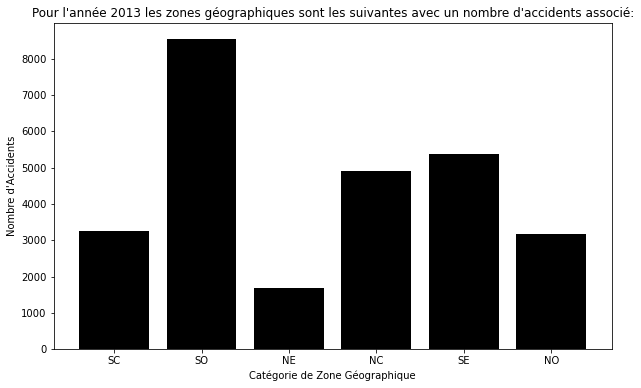

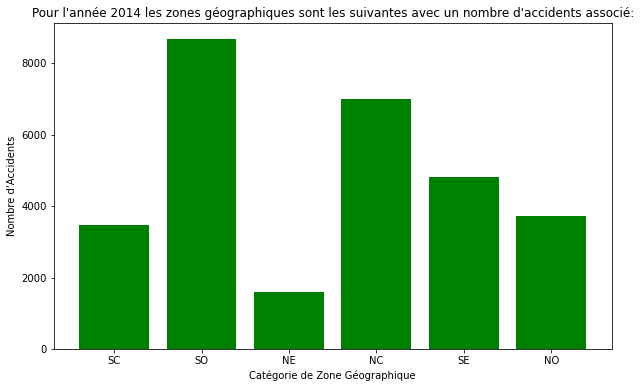

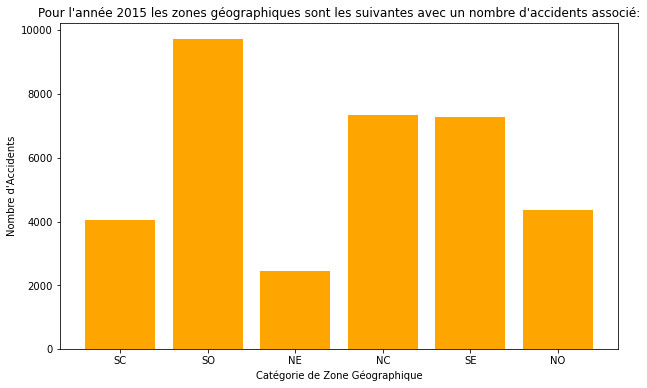

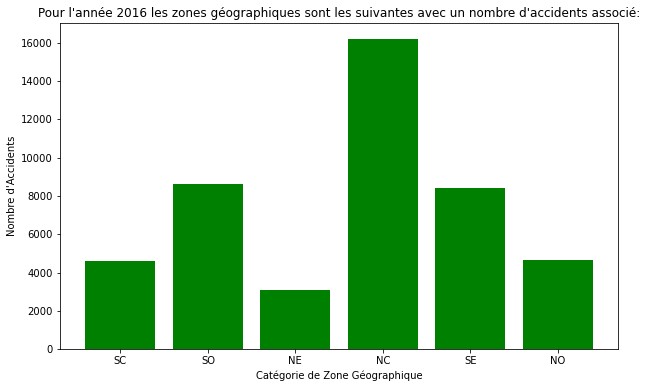

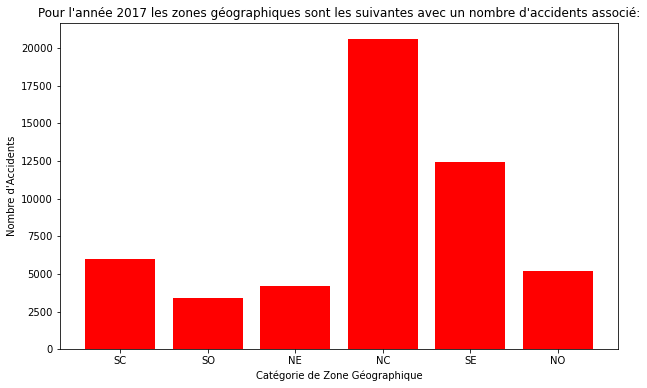

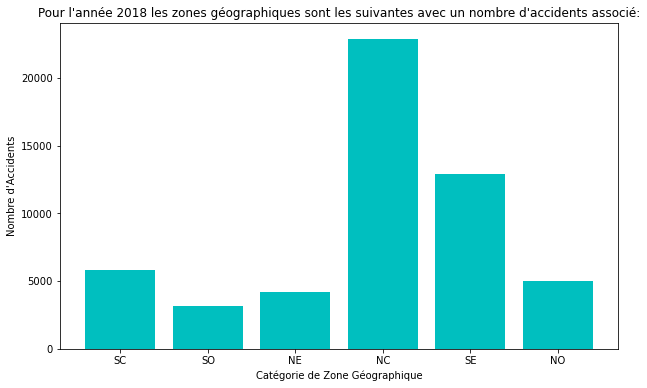

In [8]:
for a in Annees:

    spark_df = df[f'{a}'].groupBy('CAT').count() #permet de regrouper selon la CAT et de compter 
    pandas_df = spark_df.toPandas() #utile pour revenir à pandas et utiliser les méthodes d'affichages et plot 

    plt.figure(figsize=(10, 6))
    plt.bar(pandas_df['CAT'], pandas_df['count'], color=colors[a%8])  # Choisissez la couleur que vous préférez
    plt.title(f"Pour l'année {a} les zones géographiques sont les suivantes avec un nombre d'accidents associé:")
    plt.xlabel('Catégorie de Zone Géographique')
    plt.ylabel('Nombre d\'Accidents')
    plt.show()




## Les 30 villes les plus touchées par les accidents de la routes entre 2012 et 2018



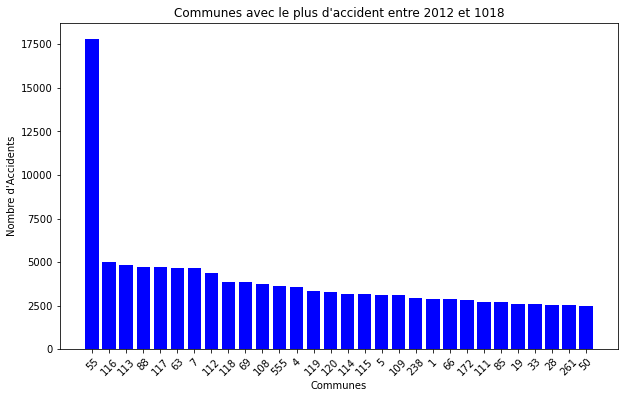

In [9]:
car_12_18 = car['car_2012']   #Initialise

# Parcourir la liste des DataFrames et les unir un par un pour obtenir un DataFrame sur toutes les années 

for a in Annees[1:]:  # Commencer à partir du deuxième élément, car le premier est déjà dans df_12_18
    car_12_18 = car_12_18.unionByName(car[f'car_{a}'])

# Group by 'com' et compter
count = car_12_18.groupBy('com').count()

# Afficher les 30 premières communes avec le plus grand nombre de lignes
spark_df = count.orderBy('count', ascending=False)
pandas_df = spark_df.toPandas().iloc[0:30]


plt.figure(figsize=(10, 6))
plt.bar(range(len(pandas_df['com'])), pandas_df['count'], color='b')  # Choisissez la couleur que vous préférez
plt.xticks(range(len(pandas_df['com'])), pandas_df['com'],rotation=45)
plt.title("Communes avec le plus d'accident entre 2012 et 1018")
plt.xlabel('Communes')
plt.ylabel('Nombre d\'Accidents')
plt.show()




Les communes avec les plus d'accidents entre 2012 et 2018 sont référencées par les index : 55, 116, 113, 88, 117, 63, 7, 112, 118, 69 ...

## Accidents par périodes de l'année entre 2012 et 2018

Pour simplifier notre étude, nous associons l'hiver aux mois de janvier, février et mars. Nous associons le printemps aux mois d'avril, mai et juin. Nous associons l'été aux mois de juillet, août et septembre. Enfin, nous associons l'automne aux mois d'octobre, novembre et décembre.


In [10]:
############################# ATTENTION ##########################################
from pyspark.sql.functions import col as Col 
#  /!\ Il y a une colonne du nom de "col" donc on change le nom pour la fonction col 

Hiver = car_12_18.filter(Col('mois').isin([1, 2, 3])).count()
Printemps = car_12_18.filter(Col('mois').isin([4, 5, 6])).count()
Ete = car_12_18.filter(Col('mois').isin([7, 8, 9])).count()
Automne = car_12_18.filter(Col('mois').isin([10, 11, 12])).count()

print("Entre 2012 et 2018 le nombre d'accidents suivant la période de l'année :")
print("Hiver = ", Hiver)
print("Printemps = ",Printemps )
print("Ete= ",Ete )
print("Automne  = ",Automne )

Entre 2012 et 2018 le nombre d'accidents suivant la période de l'année :
Hiver =  92382
Printemps =  108118
Ete=  106160
Automne  =  110411


In [13]:

M = (Hiver +Printemps+Ete+Automne)/4
print(Automne/M)
print(Hiver/M)

1.0589180259476205
0.8860074184011835


Le nombre d'accidents en Automne est 5% plus plus grand que le nombre moyen d'accidents par période. À l'inverse le nombre d'accidents en Hiver est 11% plus plus petit que le nombre moyen d'accidents par période.

## Nombre d'accidents en fonction de l'éclairage et du niveau d'aglomération:

Dans cette partie, nous allons étudier la distribution des accidents de la route sous le spectre du niveau d'éclairage au moment de l'accident. Nous étudierons ensuite le lien avec le niveau d'aglomération. 



1 Plein jour,

2 Crépuscule ou aube,

3 Nuit sans éclairage public,

4 Nuit avec éclairage public non allumé,

5 Nuit avec éclairage public allumé.

In [13]:
car_12_18.groupBy('lum').count().orderBy("count",ascending=False).show()
car_12_18.groupBy('agg').count().show()
car_12_18.groupBy(['lum','agg']).count().orderBy("count",ascending=False).show()

+---+------+
|lum| count|
+---+------+
|  1|284241|
|  5| 68148|
|  3| 34910|
|  2| 25989|
|  4|  3783|
+---+------+



+---+------+
|agg| count|
+---+------+
|  1|139882|
|  2|277189|
+---+------+



+---+---+------+
|lum|agg| count|
+---+---+------+
|  1|  2|191200|
|  1|  1| 93041|
|  5|  2| 62099|
|  3|  1| 29296|
|  2|  2| 16048|
|  2|  1|  9941|
|  5|  1|  6049|
|  3|  2|  5614|
|  4|  2|  2228|
|  4|  1|  1555|
+---+---+------+



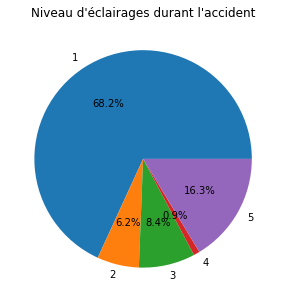

In [14]:
# récupérer le résultat avec la commande collect()
result = car_12_18.groupBy('lum').count().orderBy("lum",ascending=True).collect()

# Conversion array et construire une matrice 
matrix = np.array([(row['lum'], row['count']) for row in result]) 

P = matrix[:,1]/matrix[:,1].sum() #ligne des probas
L = matrix[:,0] # ligne des éclairages 

M = np.stack((L,P))


# Création des pie plots pour chaque ligne de la matrice
fig, axs = plt.subplots(1, 1, figsize=(10, 5))  
# Diagramme en secteurs pour la première ligne
axs.pie(P, labels=L, autopct='%1.1f%%')
axs.set_title('Niveau d\'éclairages durant l\'accident')
# Affichage des diagrammes
plt.show()


Il n'y a pas équiprobabilité sur le niveau de luminosité sachant qu'il y a eu un accident.  

In [15]:
# récupérer le résultat avec la commande collect()
result = car_12_18.groupBy(['lum','agg']).count().orderBy("count",ascending=False).collect()

# Conversion array
matrix = np.array([(row['lum'], row['agg'],row['count']) for row in result])


P = matrix[:,2]/matrix[:,2].sum()
P= P.reshape((P.shape[0],1))
L = matrix[:,0:2]

M = np.round(np.hstack((L,P)),2)
M

array([[1.  , 2.  , 0.46],
       [1.  , 1.  , 0.22],
       [5.  , 2.  , 0.15],
       [3.  , 1.  , 0.07],
       [2.  , 2.  , 0.04],
       [2.  , 1.  , 0.02],
       [5.  , 1.  , 0.01],
       [3.  , 2.  , 0.01],
       [4.  , 2.  , 0.01],
       [4.  , 1.  , 0.  ]])

Localisation :
1 – Hors agglomération
2 – En agglomération

On remarque que les accidents arrivent particulièrement en plein jour et presque une fois sur deux en ville et en plein jour. On remarque que 7% des accidents arrivent en pleine nuit dans des des lieux sans éclairage public et en campagne. 



### Intéressons nous sur le type de d'obstacle rencontré ou non pour cette catégorie ([3.  , 1.])



In [11]:
car_12_18.groupBy(['Num_Acc']).count().orderBy('count',ascending=False).show(3)
#Cette commande nous permet de vérifier que chaque accident à un unique identifiant au niveau des caractéristiques. 

car_3_1_12_18 = car_12_18.filter(Col('lum')=="3" ).filter(Col('agg')==1)

car_3_1_12_18.show(4)

#Créer un Dataframe avec tout les véhicules impliqué dans un accident entre 2012 et 2018
vehi_12_18 = vehi["vehi_2012"] # Initialiser 

for a in Annees[1:]:
    vehi_12_18 = vehi_12_18.unionByName(vehi[f"vehi_{a}"])

vehi_12_18.groupBy(['Num_Acc']).count().orderBy('count',ascending=False).show(4)
# On voit que plusieurs véhicules peuvent être impliqués dans un même accidents au maximum 35 véhicules pour un accident

vehi_12_18.show(4)

+------------+-----+
|     Num_Acc|count|
+------------+-----+
|201200000088|    1|
|201200000209|    1|
|201200000276|    1|
+------------+-----+
only showing top 3 rows

+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
|     Num_Acc| an|mois|jour|hrmn|lum|agg|int|atm|col|com|                 adr|gps|    lat|  long|dep|
+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
|201200000022| 12|  11|  29|2300|  3|  1|  1|  8|  7|197|    Rte de Templeuve|  M|5053890|316157|590|
|201200000035| 12|   3|  31|  15|  3|  1|  1|  1|  7|159| Rte de Coppenaxfort|  M|5096780|223629|590|
|201200000038| 12|   5|  17| 415|  3|  1|  1|  1|  6|664|          Rte de Ham|  M|5082629|224306|590|
|201200000049| 12|  11|  18|1915|  3|  1|  1|  1|  6|628|Rte de la Reine B...|  M|5083610|229335|590|
+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
only showing

+------------+-----+
|     Num_Acc|count|
+------------+-----+
|201600002473|   35|
|201300003075|   28|
|201200012658|   26|
|201200022945|   25|
+------------+-----+
only showing top 4 rows

+------------+----+----+------+---+----+----+----+-------+
|     Num_Acc|senc|catv|occutc|obs|obsm|choc|manv|num_veh|
+------------+----+----+------+---+----+----+----+-------+
|201200000001|   0|   7|     0|  0|   1|   7|  16|    A01|
|201200000002|   0|   7|     0|  0|   2|   3|  16|    A01|
|201200000002|   0|  33|     0|  0|   2|   8|   1|    B02|
|201200000003|   0|   7|     0|  0|   2|   1|   1|    C03|
+------------+----+----+------+---+----+----+----+-------+
only showing top 4 rows



In [16]:

print("num_veh différents = ",vehi_12_18.select('num_veh').distinct().count())

print("nombre de lignes = ",vehi_12_18.count())

num_veh différents =  95
nombre de lignes =  710625


Je ne pense pas que num_veh soit un identifiant unique par véhicule car il y a beaucoup trop d'accidents pour seulement 95 num_véhicules différents. 

In [12]:
#Faire la jointure sur les véhicules qui sont ref avec dans caractéristiques
vehi_12_18.join(car_3_1_12_18,vehi_12_18.Num_Acc == car_3_1_12_18.Num_Acc).show(2) 


joindf = vehi_12_18.alias('v').join(car_3_1_12_18.alias('c'),Col("v.Num_Acc") == Col("c.Num_Acc")) #Inner join par défault 

pd_df0 = joindf.filter(Col('obs')!=0).groupBy(['v.obs']).count().orderBy('count').toPandas()
pd_df = joindf.filter(Col('obsm')!=0).groupBy(['v.obsm']).count().orderBy('count').toPandas()

pd_df0["Pourcentage"] = pd_df0["count"] / pd_df0["count"].sum()
pd_df["Pourcentage"] = pd_df["count"] / pd_df["count"].sum()


+------------+----+----+------+---+----+----+----+-------+------------+---+----+----+----+---+---+---+---+---+---+---------+---+-------+------+---+
|     Num_Acc|senc|catv|occutc|obs|obsm|choc|manv|num_veh|     Num_Acc| an|mois|jour|hrmn|lum|agg|int|atm|col|com|      adr|gps|    lat|  long|dep|
+------------+----+----+------+---+----+----+----+-------+------------+---+----+----+----+---+---+---+---+---+---+---------+---+-------+------+---+
|201200001987|   0|  10|     0|  0|   1|   7|   1|    A01|201200001987| 12|   8|  14| 100|  3|  1|  1|  1|  6|131|rte bleue|  M|0000000|     0|440|
|201200002640|   0|  33|     0|  0|   2|   1|   1|    B02|201200002640| 12|  10|  29| 700|  3|  1|  1|  1|  3| 23|     NULL|  M|4469900|-49500|330|
+------------+----+----+------+---+----+----+----+-------+------------+---+----+----+----+---+---+---+---+---+---+---------+---+-------+------+---+
only showing top 2 rows



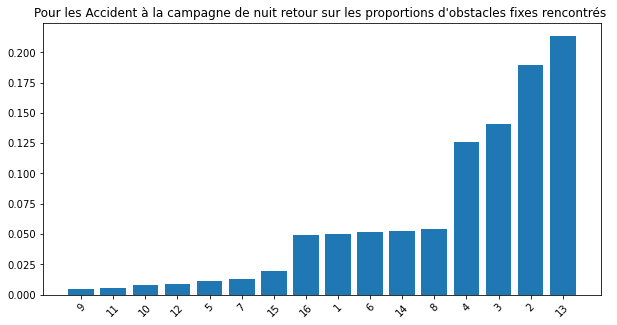

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))  
axs.bar(range(len(pd_df0["obs"])),pd_df0["Pourcentage"])
axs.set_title('Pour les Accident à la campagne de nuit retour sur les proportions d\'obstacles fixes rencontrés ')
plt.xticks(range(len(pd_df0["obs"])), pd_df0["obs"],rotation=45)
plt.show()

Obstacle fixe heurté :

1 – Véhicule en stationnement

2 – Arbre

3 – Glissière métallique

4 – Glissière béton

5 – Autre glissière

6 – Bâtiment, mur, pile de pont

7 – Support de signalisation verticale ou poste d’appel d’urgence

8 – Poteau

9 – Mobilier urbain

10 – Parapet

11 – Ilot, refuge, borne haute

12 – Bordure de trottoir

13 – Fossé, talus, paroi rocheuse

14 – Autre obstacle fixe sur chaussée

15 – Autre obstacle fixe sur trottoir ou accotement

16 – Sortie de chaussée sans obstacle

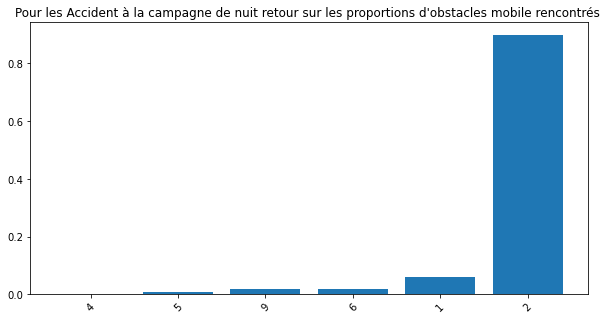

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))  
axs.bar(range(len(pd_df["obsm"])),pd_df["Pourcentage"])
axs.set_title('Pour les Accident à la campagne de nuit retour sur les proportions d\'obstacles mobile rencontrés ')
plt.xticks(range(len(pd_df["obsm"])), pd_df["obsm"],rotation=45)
plt.show()

Obstacle mobile heurté :
1 – Piéton

2 – Véhicule

4 – Véhicule sur rail

5 – Animal domestique

6 – Animal sauvage

9 – Autre

## Nombre de personnes tués sur la route, blessés, blésées grave et indemnes à la suite d'un accident

Dans cette partie, nous allons travailler avec les DataFrame "user" en sachant que le sexe 1 est male et le sexe 2 est femelle. 

In [33]:
type_grav = range(1,5)
nb_us_grav= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité
nb_us_grav_m= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + male
nb_us_grav_f= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + female

for a in Annees:
    for g in type_grav:
        nb_us_grav[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).count())
        nb_us_grav_m[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==1).count()) 
        nb_us_grav_f[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==2).count())


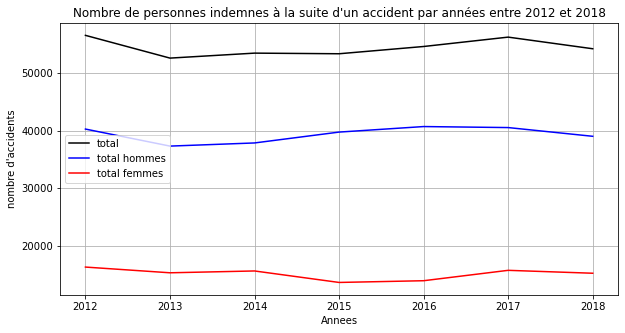

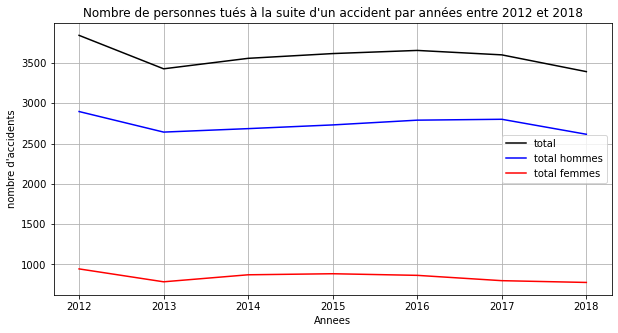

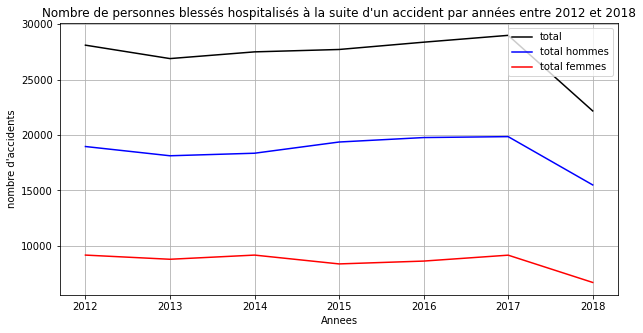

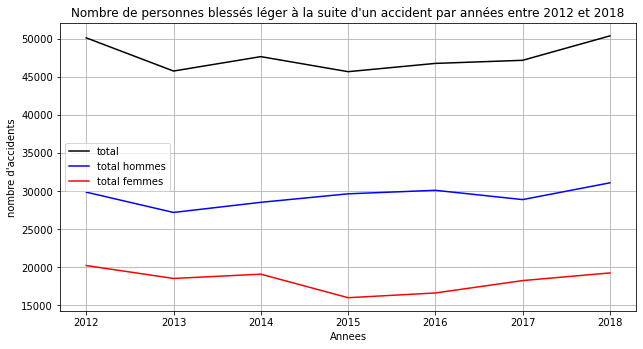

In [37]:
verb_grave= {1:'indemnes',2:'tués',3:'blessés hospitalisés',4:'blessés léger'}



for g in range(1,5):
    plt.figure(figsize=(10,5))
    plt.plot(Annees,nb_us_grav[f'grave{g}'],c='k',label='total')
    plt.plot(Annees,nb_us_grav_m[f'grave{g}'],c='b',label='total hommes')
    plt.plot(Annees,nb_us_grav_f[f'grave{g}'],c='r',label='total femmes')
    plt.ylabel("nombre d'accidents")
    plt.xlabel('Annees')
    plt.grid()
    plt.title(f"Nombre de personnes {verb_grave[g]} à la suite d'un accident par années entre 2012 et 2018" )
    plt.legend()

# Ajustement de l'espacement
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

plt.show()

In [27]:
#Nombre d'accidents par type de colision 

type_grav = range(1,5)
nb_us_grav_c= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + conducteur
nb_us_grav_m_c= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + male + conducteur
nb_us_grav_f_c= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + female + 

nb_us_grav_pa= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + passager
nb_us_grav_m_pa= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + male + passager
nb_us_grav_f_pa= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + female + passager

nb_us_grav_p= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + piéton
nb_us_grav_m_p= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + male + piéton
nb_us_grav_f_p= {f'grave{i}':[] for i in type_grav} # Dico avec une liste par type de gravité + female + piéton

for a in Annees:
    for g in type_grav:
        nb_us_grav_c[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('catu')==1).count())
        nb_us_grav_m_c[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==1).filter(Col('catu')==1).count()) 
        nb_us_grav_f_c[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==2).filter(Col('catu')==1).count())

        nb_us_grav_pa[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('catu')==2).count())
        nb_us_grav_m_pa[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==1).filter(Col('catu')==2).count()) 
        nb_us_grav_f_pa[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==2).filter(Col('catu')==2).count())

        nb_us_grav_p[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('catu')==3).count())
        nb_us_grav_m_p[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==1).filter(Col('catu')==3).count()) 
        nb_us_grav_f_p[f'grave{g}'].append(usa[f'usa_{a}'].filter(Col('grav')==g).filter(Col('sexe')==2).filter(Col('catu')==3).count())


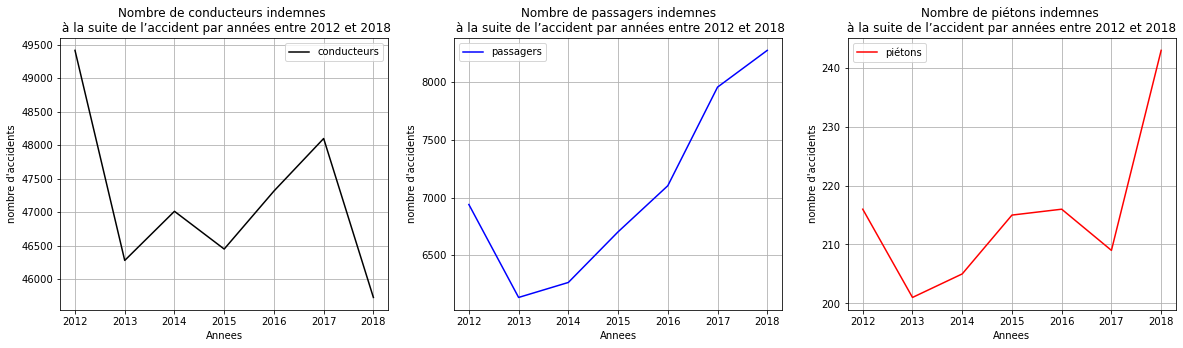

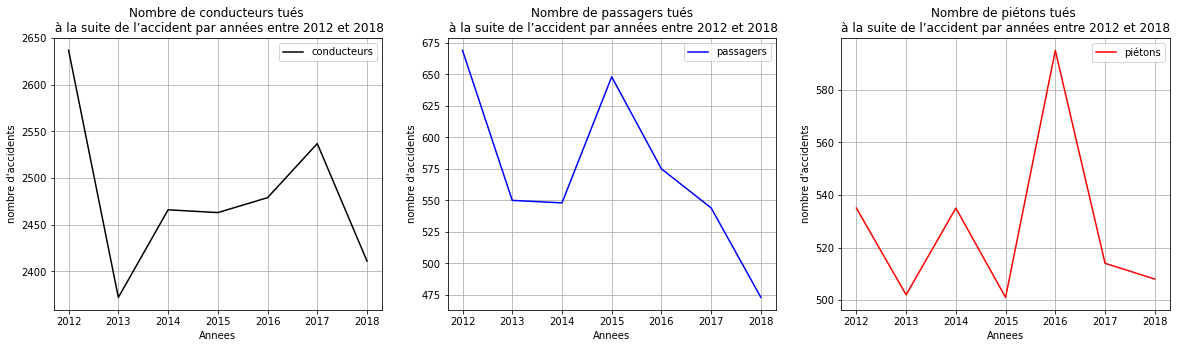

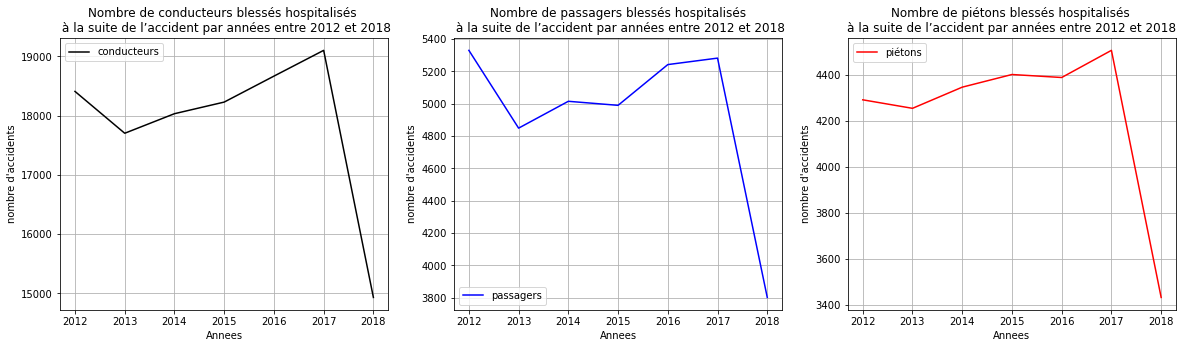

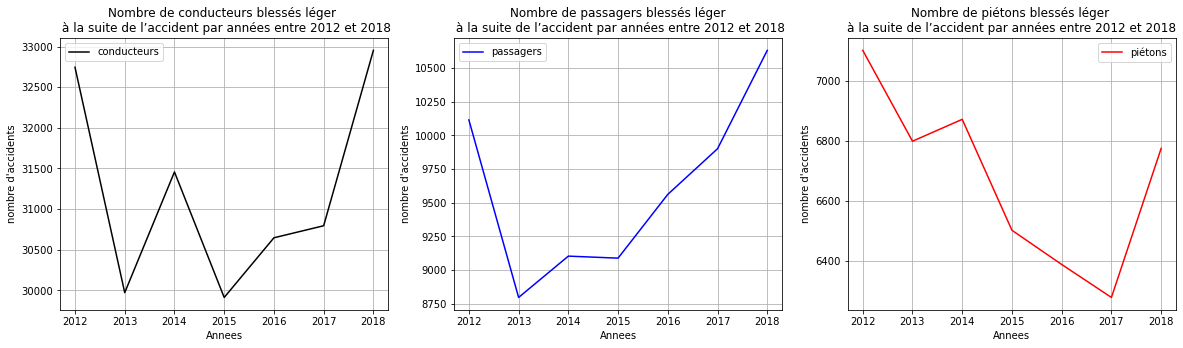

<Figure size 432x288 with 0 Axes>

In [28]:
verb_grave= {1:'indemnes',2:'tués',3:'blessés hospitalisés',4:'blessés léger'}


for g in range(1,5):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.plot(Annees,nb_us_grav_c[f'grave{g}'],c='k',label='conducteurs')
    plt.ylabel("nombre d'accidents")
    plt.xlabel('Annees')
    plt.grid()
    plt.title(f"Nombre de conducteurs {verb_grave[g]} \n à la suite de l’accident par années entre 2012 et 2018" )
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(Annees,nb_us_grav_pa[f'grave{g}'],c='b',label='passagers')
    plt.ylabel("nombre d'accidents")
    plt.xlabel('Annees')
    plt.grid()
    plt.title(f"Nombre de passagers {verb_grave[g]}\n à la suite de l’accident par années entre 2012 et 2018" )
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(Annees,nb_us_grav_p[f'grave{g}'],c='r',label='piétons')
    plt.ylabel("nombre d'accidents")
    plt.xlabel('Annees')
    plt.grid()
    plt.title(f"Nombre de piétons {verb_grave[g]} \nà la suite de l’accident par années entre 2012 et 2018" )
    plt.legend()
    plt.show()

# Ajustement de l'espacement
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

plt.show()

# Les 10 catégories de véhicules les plus meurtrières sur ces années pour les conducteurs

In [13]:
usa_12_18 = usa['usa_2012'].withColumn("âge", 2012 - Col("an_nais"))   #Initialise et rajoute une colonne âge

# Parcourir la liste des DataFrames et les unir un par un pour obtenir un DataFrame sur toutes les années 

for a in Annees[1:]:
    usa_12_18 = usa_12_18.unionByName(usa[f'usa_{a}'].withColumn("âge", a - Col("an_nais")) )



In [14]:
usa_12_18_mort = usa_12_18.filter(Col('grav')==2).filter(Col('catu')==1) #Fait un filtre sur les usagers morts comme conducteur

join_usa_vehi = usa_12_18_mort.alias('u').join(vehi_12_18.alias('v'),Col("u.Num_Acc") == Col("v.Num_Acc"))

pd_df = join_usa_vehi.groupBy('catv').count().orderBy('count',ascending=False).toPandas()

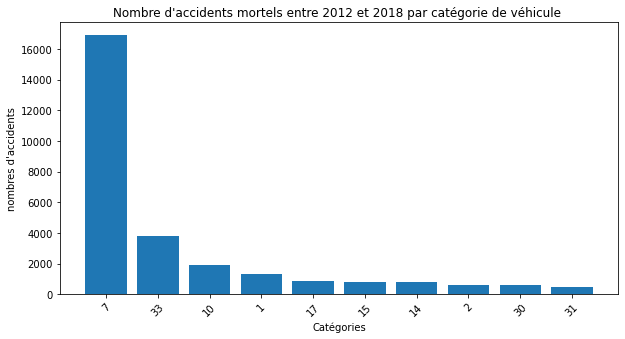

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))  
axs.bar(range(10),pd_df[0:10]['count'])
axs.set_title('Nombre d\'accidents mortels entre 2012 et 2018 par catégorie de véhicule ')
plt.xticks(range(10), pd_df.iloc[0:10]['catv'],rotation=45)
plt.xlabel('Catégories')
plt.ylabel('nombres d\'accidents')
plt.show()



Catégorie du véhicule :

07 - VL seul, (véhicules légers inférieur ou égal à 3,5 tonnes)

33 - Motocyclette > 125 cm3

10 - VU seul 1,5T <= PTAC <= 3,5T avec ou sans remorque (anciennement VU seul 1,5T <= PTAC <=
3,5T) (véhicule utilitaire)

01 - Bicyclette

17 - Tracteur routier + semi-remorque

15 - PL > 3,5T + remorque

14 - PL seul > 7,5T

02 - Cyclomoteur <50cm3

30 - Scooter < 50 cm3

31 - Motocyclette > 50 cm3 et <= 125 cm3

# Classe d'âge la plus touchée dans des accidents meurtriers sur la route pour les conducteurs

Nous aurions aimé utiliser le DataFrame usa_12_18_mort qui recence les conducteurs morts sur la route entre 2012 et 2018. Malheureusement il nous manque l'âge du conducteur dans une colonne. Nous allons modifier notre code en amont pour faire apparaître cette colonne qui dépend de l'année des tableaux qui constituent usa_12_18_mort. 

In [15]:
# Ajout de la colonne 'age_category' basée sur des tranches d'âge définies
usa_12_18_mort = usa_12_18_mort.withColumn(
    'age_category',
    when(Col('âge') < 18, '0-17')
    .when((Col('âge') >= 18) & (Col('âge') < 25), '18-24')
    .when((Col('âge') >= 25) & (Col('âge') < 35), '25-34')
    .when((Col('âge') >= 35) & (Col('âge') < 45), '35-44')
    .when((Col('âge') >= 45) & (Col('âge') < 55), '45-54')
    .when((Col('âge') >= 55) & (Col('âge') < 65), '55-64')
    .otherwise('65+')
)

usa_12_18_mort.show(4)

+------------+-----+----+----+----+------+----+----+----+-----+-------+-------+---+------------+
|     Num_Acc|place|catu|grav|sexe|trajet|secu|locp|actp|etatp|an_nais|num_veh|âge|age_category|
+------------+-----+----+----+----+------+----+----+----+-----+-------+-------+---+------------+
|201200000010|    1|   1|   2|   1|     5|  11|   0|   0|    0|   1987|    A01| 25|       25-34|
|201200000015|    1|   1|   2|   1|     5|  21|   0|   0|    0|   1991|    A01| 21|       18-24|
|201200000037|    1|   1|   2|   1|     5|  11|   0|   0|    0|   1993|    A01| 19|       18-24|
|201200000038|    1|   1|   2|   1|     5|  12|   0|   0|    0|   1977|    A01| 35|       35-44|
+------------+-----+----+----+----+------+----+----+----+-----+-------+-------+---+------------+
only showing top 4 rows



In [16]:

age_category_counts = usa_12_18_mort.groupBy('age_category').count().orderBy('age_category').toPandas()
age_m_category_counts = usa_12_18_mort.filter(Col("sexe")==1).groupBy('age_category').count().orderBy('age_category').toPandas()
age_f_category_counts = usa_12_18_mort.filter(Col("sexe")==2).groupBy('age_category').count().orderBy('age_category').toPandas()

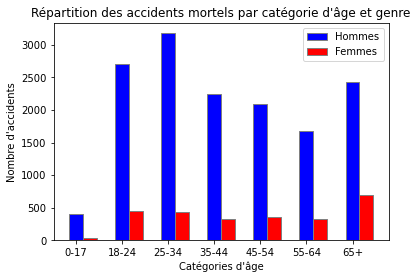

In [17]:

# Largeur des barres dans le barplot
bar_width = 0.3

# Fixer les positions des barres sur l'axe X
r1 = range(len(age_category_counts))
r2 = [x + bar_width for x in r1]

# Créer les barres pour les hommes et les femmes
plt.bar(r1, age_m_category_counts['count'], color='b', width=bar_width, edgecolor='grey', label='Hommes')
plt.bar(r2, age_f_category_counts['count'], color='r', width=bar_width, edgecolor='grey', label='Femmes')

# Ajouter des légendes aux barres
plt.xlabel('Catégories d\'âge')
plt.ylabel('Nombre d\'accidents')
plt.title('Répartition des accidents mortels par catégorie d\'âge et genre')
plt.xticks(range(len(age_category_counts)), age_category_counts['age_category'])

# Créer la légende et afficher le graphique
plt.legend()
plt.show()

# Les 100 personnes les plus impliquées dans des accidents de la route sur ces années d'études 

Cette questions restera sans réponse car nous n'avons pas de colonne avec un identifiant unique pour chaque usager. Il semblerait que chaque ligne correspond à un usagers impliqué dans un unique accident, rien nous permet de dire si le même individu peut se retrouver plusieurs fois dans ce tableau et comment l'identifier. 

In [47]:
usa_12_18 = usa['usa_2012']

for a in Annees[1:]:
    usa_12_18 = usa_12_18.unionByName(usa[f'usa_{a}'])

usa_12_18.filter(Col('num_veh') == 'A01').count() # 565758 

#Résultat qui me semble pas cohérent car une voiture ne peut pas être associée à 565758 personnes

565758